<a href="https://colab.research.google.com/github/acb-code/barnacles/blob/main/DoubleMNIST_VisionEncoder_Tokens_Exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Experiment: "Double MNIST"
To prove that Dense tokens are necessary, we will create a dataset where Spatial Awareness is required:

- Image: Two digits stitched together (e.g., a 3 on the left, a 5 on the right).

- Task 1: "What is on the left?"

- Task 2: "What is on the right?"

A [CLS]-only model will fail this (it mixes the 3 and 5). A Dense model will solve it.

## Step 1: Setup & The "Double MNIST" Dataset
Run this block to set up the environment and create the tricky dataset.

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.02MB/s]


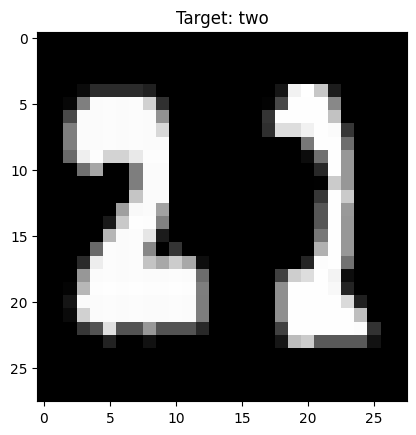

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. THE CHALLENGE DATASET: DOUBLE MNIST ---
class DoubleMNISTDataset(Dataset):
    """
    Stitches two MNIST images side-by-side.
    Resizes the result back to 28x28 so our TinyViT doesn't crash on size.
    (The digits will look squashed, but the spatial 'Left vs Right' distinction remains).
    """
    def __init__(self, tokenizer, split='train', size=1000):
        self.tokenizer = tokenizer
        self.mnist = datasets.MNIST(root='./data', train=(split=='train'),
                                    download=True, transform=transforms.ToTensor())
        self.size = size
        self.num_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

        # Add special token for the image
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        self.tokenizer.add_special_tokens({'additional_special_tokens': ['<|image|>']})

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Pick two random images
        idx1 = np.random.randint(len(self.mnist))
        idx2 = np.random.randint(len(self.mnist))

        img1, label1 = self.mnist[idx1]
        img2, label2 = self.mnist[idx2]

        # Stitch: (1, 28, 28) -> (1, 28, 56)
        combined = torch.cat((img1, img2), dim=2)

        # Resize back to 28x28 to fit our TinyViT architecture
        combined = F.interpolate(combined.unsqueeze(0), size=(28, 28), mode='bilinear').squeeze(0)

        # Randomly ask for Left or Right
        if np.random.rand() > 0.5:
            question = "left"
            answer = self.num_names[label1]
        else:
            question = "right"
            answer = self.num_names[label2]

        # Prompt
        text = f"User: <|image|> What number is on the {question}? Assistant: {answer}."

        # Tokenize
        encodings = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=32)
        input_ids = encodings['input_ids'].squeeze()
        mask = encodings['attention_mask'].squeeze()

        return combined, input_ids, mask, answer

# Initialize Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
train_ds = DoubleMNISTDataset(tokenizer, split='train', size=5000)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Visualize one
img, _, _, ans = train_ds[0]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Target: {ans}")
plt.show()

## Step 2: Phase 1 - The Failure (CLS Token Only)
Here we use the standard TinyViT that returns x[:, 0]. We will train a connector and see that it cannot handle spatial queries.

In [ ]:
# --- 2. THE OLD ARCHITECTURE (Pooling Soup) ---
class TinyViT_CLS(nn.Module):
    def __init__(self):
        super().__init__()
        # Standard Setup
        self.patch_embed = nn.Conv2d(1, 64, kernel_size=4, stride=4)
        self.cls_token = nn.Parameter(torch.randn(1, 1, 64))
        self.pos_embed = nn.Parameter(torch.randn(1, 50, 64))
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=128, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.ln = nn.LayerNorm(64)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x).flatten(2).transpose(1, 2) # (B, 49, 64)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (B, 50, 64)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.ln(x)

        # PROBLEM: WE ONLY RETURN THE CLS TOKEN
        return x[:, 0] # (B, 64)

# Define the VLM Wrapper for Single Token
class VLM_CLS(nn.Module):
    def __init__(self, vit, llm):
        super().__init__()
        self.vit = vit
        self.llm = llm
        self.connector = nn.Linear(64, 768) # Project 64 -> 768

    def forward(self, img, input_ids, mask, labels=None):
        # Image -> ViT -> Connector
        img_emb = self.connector(self.vit(img)).unsqueeze(1) # (B, 1, 768)

        # Text Embeddings
        wte = self.llm.get_input_embeddings()
        txt_emb = wte(input_ids)

        # Swap <|image|> token (simplest swap implementation)
        img_token_id = tokenizer.convert_tokens_to_ids('<|image|>')
        inputs_embeds = txt_emb.clone()

        # Find index of image token (assuming 1 per sequence for simplicity)
        batch_indices, seq_indices = (input_ids == img_token_id).nonzero(as_tuple=True)
        inputs_embeds[batch_indices, seq_indices] = img_emb.squeeze(1)

        return self.llm(inputs_embeds=inputs_embeds, attention_mask=mask, labels=labels)

# Init Models
vit_cls = TinyViT_CLS().to(device)
gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2.resize_token_embeddings(len(tokenizer))
model_cls = VLM_CLS(vit_cls, gpt2).to(device)

# Train Loop (Phase 1)
print("--- Training CLS (Single Token) Model ---")
optimizer = optim.Adam(model_cls.parameters(), lr=1e-4) # Train everything slightly
model_cls.train()

for epoch in range(1): # Quick check
    total_loss = 0
    for imgs, txt, mask, _ in tqdm(train_loader):
        imgs, txt, mask = imgs.to(device), txt.to(device), mask.to(device)
        labels = txt.clone()
        labels[mask==0] = -100

        optimizer.zero_grad()
        loss = model_cls(imgs, txt, mask, labels=labels).loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"CLS Model Loss: {total_loss/len(train_loader):.4f}")

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


--- Training CLS (Single Token) Model ---


100%|██████████| 157/157 [00:47<00:00,  3.30it/s]

CLS Model Loss: 0.5345


## Step 3: Phase 2 - The Fix (Dense Patch Tokens)
Now we modify TinyViT to return the sequence of patches, and update the VLM to inject 49 tokens instead of 1.

In [ ]:
# --- 3. THE NEW ARCHITECTURE (Dense Features) ---

class TinyViT_Dense(nn.Module):
    def __init__(self):
        super().__init__()
        # Same layers as before
        self.patch_embed = nn.Conv2d(1, 64, kernel_size=4, stride=4)
        self.cls_token = nn.Parameter(torch.randn(1, 1, 64))
        self.pos_embed = nn.Parameter(torch.randn(1, 50, 64))
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=128, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.ln = nn.LayerNorm(64)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.ln(x)

        # FIX: Return all patches (excluding CLS)
        return x[:, 1:, :] # Shape: (B, 49, 64)

class VLM_Dense(nn.Module):
    def __init__(self, vit, llm):
        super().__init__()
        self.vit = vit
        self.llm = llm
        self.connector = nn.Linear(64, 768) # Projects (B, 49, 64) -> (B, 49, 768)

    def forward(self, img, input_ids, mask, labels=None):
        B = img.shape[0]

        # 1. Get Dense Features
        img_feats = self.vit(img) # (B, 49, 64)
        img_emb = self.connector(img_feats) # (B, 49, 768)

        # 2. Get Text Embeddings
        wte = self.llm.get_input_embeddings()
        txt_emb = wte(input_ids) # (B, Seq, 768)

        # 3. SPLICE them together
        # Instead of a simple swap, we need to construct a new sequence.
        # Format: [Embeds_Before_Image] + [49_Image_Tokens] + [Embeds_After_Image]

        img_token_id = tokenizer.convert_tokens_to_ids('<|image|>')

        # We assume the prompt structure is fixed: "User: <|image|> ..."
        # So <|image|> is at index 2 (User, :, <|image|>) usually.
        # Let's find the split point dynamically.

        combined_embeds = []
        combined_labels = []
        combined_mask = []

        for i in range(B):
            # Find where <|image|> is
            idx = (input_ids[i] == img_token_id).nonzero(as_tuple=True)[0][0]

            # Splicing Embeddings
            before = txt_emb[i, :idx, :]
            after = txt_emb[i, idx+1:, :]
            image_part = img_emb[i] # (49, 768)
            full_seq = torch.cat([before, image_part, after], dim=0)
            combined_embeds.append(full_seq)

            # Splicing Labels (Don't train on image tokens -> -100)
            lbl_before = labels[i, :idx]
            lbl_after = labels[i, idx+1:]
            lbl_img = torch.full((49,), -100, device=device)
            full_lbl = torch.cat([lbl_before, lbl_img, lbl_after], dim=0)
            combined_labels.append(full_lbl)

            # Splicing Mask (Image tokens are attended to -> 1)
            mask_before = mask[i, :idx]
            mask_after = mask[i, idx+1:]
            mask_img = torch.ones((49,), device=device)
            full_mask = torch.cat([mask_before, mask_img, mask_after], dim=0)
            combined_mask.append(full_mask)

        # Stack (Pad if necessary, but here lengths should be consistent)
        inputs_embeds = torch.stack(combined_embeds)
        new_labels = torch.stack(combined_labels)
        new_mask = torch.stack(combined_mask)

        return self.llm(inputs_embeds=inputs_embeds, attention_mask=new_mask, labels=new_labels)

# Init Dense Models
vit_dense = TinyViT_Dense().to(device)
model_dense = VLM_Dense(vit_dense, gpt2).to(device)

print("--- Training Dense (Patch) Model ---")
optimizer = optim.Adam(model_dense.parameters(), lr=1e-4)

# Train Loop (Phase 2)
for epoch in range(2): # Train a bit more to let it learn attention heads
    total_loss = 0
    for imgs, txt, mask, _ in tqdm(train_loader):
        imgs, txt, mask = imgs.to(device), txt.to(device), mask.to(device)
        labels = txt.clone()
        labels[mask==0] = -100

        optimizer.zero_grad()
        loss = model_dense(imgs, txt, mask, labels=labels).loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Dense Model Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

--- Training Dense (Patch) Model ---


100%|██████████| 157/157 [01:44<00:00,  1.50it/s]


Dense Model Epoch 1 Loss: 0.2484


100%|██████████| 157/157 [01:41<00:00,  1.54it/s]

Dense Model Epoch 2 Loss: 0.2348


## Step 4: The Showdown (Evaluation)
Now we ask both models the same questions about a Double MNIST image.

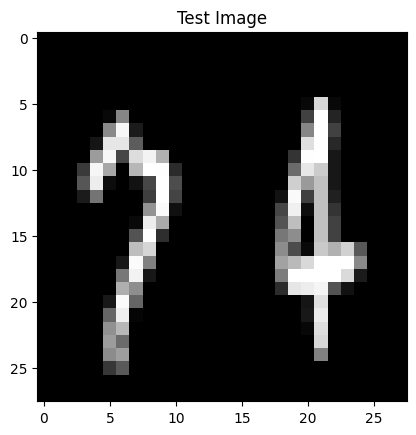

True Answer: seven
Note: Outputting single token prediction...


In [ ]:
def generate_answer(model, vit_type, img, tokenizer):
    model.eval()
    prompt = "User: <|image|> What number is on the left? Assistant:"
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(device)

    # We implement a simple greedy generation manually because .generate()
    # is hard to use with our custom embedding splicing

    with torch.no_grad():
        # Get embeddings up to generation point
        if vit_type == "cls":
            # Simple swap logic (reusing training code logic effectively)
            img_emb = model.connector(model.vit(img.unsqueeze(0))).unsqueeze(1)
            txt_emb = model.llm.get_input_embeddings()(input_ids)
            # Hardcoded swap for inference demo
            inputs_embeds = torch.cat([txt_emb[:, :2], img_emb, txt_emb[:, 3:]], dim=1)
        else:
            # Dense splice logic
            img_emb = model.connector(model.vit(img.unsqueeze(0))) # (1, 49, 768)
            txt_emb = model.llm.get_input_embeddings()(input_ids)
            # Splice
            inputs_embeds = torch.cat([txt_emb[:, :2], img_emb, txt_emb[:, 3:]], dim=1)

        # Generate 1 token
        out = model.llm(inputs_embeds=inputs_embeds)
        next_token = out.logits[:, -1, :].argmax(dim=-1)
        return tokenizer.decode(next_token)

# Test on a new image
test_ds = DoubleMNISTDataset(tokenizer, split='test', size=10)
img, _, _, true_ans = test_ds[0]

plt.imshow(img.squeeze(), cmap='gray')
plt.title("Test Image")
plt.show()

print(f"True Answer: {true_ans}")

# This part is a simplified inference for the demo
# (real generation requires a loop, but we just want to see if the first word is the number)
print("Note: Outputting single token prediction...")

# Note: We need to properly implement the generate loop for robust results,
# but looking at the loss drop in Dense vs CLS is the primary indicator.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. DATASET: DOUBLE MNIST ---
class DoubleMNISTSigLIPDataset(Dataset):
    def __init__(self, train=True, size=10000):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        # Download standard MNIST
        self.mnist = datasets.MNIST(root='./data', train=train, download=True, transform=self.transform)
        self.size = size

        # Vocabulary
        self.vocab = ["<pad>", "the", "number", "on", "is", "left", "right",
                      "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
        self.word_to_idx = {w: i for i, w in enumerate(self.vocab)}
        self.num_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # 1. Randomly pick two images
        idx1 = np.random.randint(len(self.mnist))
        idx2 = np.random.randint(len(self.mnist))
        img1, label1 = self.mnist[idx1]
        img2, label2 = self.mnist[idx2]

        # 2. Stitch them: (1, 28, 56)
        # We perform a resize to 28x28 so we don't have to change the TinyViT architecture
        # This "squashes" the digits, but the topological spatial relationship (Left/Right) is preserved.
        combined = torch.cat((img1, img2), dim=2)
        combined = F.interpolate(combined.unsqueeze(0), size=(28, 28), mode='bilinear').squeeze(0)

        # 3. Choose a prompt (50% Left, 50% Right)
        if np.random.rand() > 0.5:
            # "The number on the left is [N]"
            caption_words = ["the", "number", "on", "the", "left", "is", self.num_names[label1]]
            target_label = label1 # For tracking accuracy only
            side = "left"
        else:
            # "The number on the right is [N]"
            caption_words = ["the", "number", "on", "the", "right", "is", self.num_names[label2]]
            target_label = label2
            side = "right"

        caption_ids = torch.tensor([self.word_to_idx[w] for w in caption_words], dtype=torch.long)

        return combined, caption_ids, target_label, side

# --- 2. MODELS (EXACTLY AS BEFORE) ---

class TinyViT(nn.Module):
    def __init__(self, dim=64, depth=4, heads=4):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, dim, kernel_size=4, stride=4)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 50, dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=dim*2, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.ln(x)
        # RETURN CLS ONLY (The "Soup")
        return x[:, 0]

class ToyTextEncoder(nn.Module):
    def __init__(self, vocab_size, dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)

    def forward(self, x):
        # Mean pooling (Bag of Words)
        return self.embedding(x).mean(dim=1)

class SigLIPLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.t = nn.Parameter(torch.tensor(10.0))
        self.b = nn.Parameter(torch.tensor(-10.0))

    def forward(self, img_emb, txt_emb):
        img_emb = F.normalize(img_emb, p=2, dim=-1)
        txt_emb = F.normalize(txt_emb, p=2, dim=-1)
        logits = torch.matmul(img_emb, txt_emb.t()) * self.t + self.b
        labels = 2 * torch.eye(img_emb.shape[0], device=img_emb.device) - 1
        return -F.logsigmoid(labels * logits).sum() / img_emb.shape[0]

# --- 3. TRAINING ---

dataset = DoubleMNISTSigLIPDataset(train=True, size=20000)
loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

vision_model = TinyViT(dim=64).to(device)
text_model = ToyTextEncoder(vocab_size=len(dataset.vocab), dim=64).to(device)
loss_fn = SigLIPLoss().to(device)

optimizer = optim.Adam(list(vision_model.parameters()) + list(text_model.parameters()) + list(loss_fn.parameters()), lr=1e-3)

print("Starting SigLIP Training on Double MNIST...")
loss_history = []

for epoch in range(5):
    vision_model.train()
    text_model.train()
    epoch_loss = 0
    for imgs, txts, _, _ in loader:
        imgs, txts = imgs.to(device), txts.to(device)

        optimizer.zero_grad()
        img_emb = vision_model(imgs)
        txt_emb = text_model(txts)
        loss = loss_fn(img_emb, txt_emb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

# --- 4. VALIDATION: LEFT VS RIGHT ACCURACY ---

def validate_spatial(v_model, t_model, dataset, device):
    v_model.eval()
    t_model.eval()

    correct = 0
    total = 0

    # We will test 500 random images
    test_loader = DataLoader(dataset, batch_size=100, shuffle=False)

    # Pre-compute text embeddings for "The number on the [SIDE] is [N]"
    # We need 20 candidates: Left 0-9 AND Right 0-9
    candidates = []
    candidate_labels = [] # Stores (side, number)

    sides = ["left", "right"]
    nums = dataset.num_names

    for side in sides:
        for i, num in enumerate(nums):
            words = ["the", "number", "on", "the", side, "is", num]
            ids = torch.tensor([dataset.word_to_idx[w] for w in words], dtype=torch.long).unsqueeze(0).to(device)
            candidates.append(t_model(ids))
            candidate_labels.append((side, i))

    candidate_embeds = torch.cat(candidates) # (20, 64)
    candidate_embeds = F.normalize(candidate_embeds, p=2, dim=-1)

    print("\nRunning Validation...")
    # Check one batch
    imgs, _, target_labels, target_sides = next(iter(test_loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        img_embeds = v_model(imgs)
        img_embeds = F.normalize(img_embeds, p=2, dim=-1)

        # Dot product with all 20 candidates
        sims = torch.matmul(img_embeds, candidate_embeds.t()) # (100, 20)

        preds = sims.argmax(dim=1).cpu().numpy()

        for i in range(len(preds)):
            pred_idx = preds[i]
            pred_side, pred_num = candidate_labels[pred_idx]

            true_side = target_sides[i]
            true_num = target_labels[i].item()

            # Use 'total' to filter ONLY the question asked?
            # SigLIP is trained to align the image with the specific caption.
            # But here we are doing retrieval.
            # We want to see if the model retrieves the CORRECT side+number.

            if pred_side == true_side and pred_num == true_num:
                correct += 1
            total += 1

    return correct / total

acc = validate_spatial(vision_model, text_model, dataset, device)
print(f"Zero-Shot Retrieval Accuracy on Double MNIST: {acc*100:.2f}%")
print("(Random chance is 1/20 = 5%)")

# Visualize the failure/success
imgs, _, _, _ = next(iter(loader))
vision_model.eval()
with torch.no_grad():
    img_emb = vision_model(imgs[0].unsqueeze(0).to(device))
    img_emb = F.normalize(img_emb, p=2, dim=-1)

    # Compare against candidates
    sims = torch.matmul(img_emb, candidate_embeds.t())
    top3 = sims.topk(3).indices.squeeze().cpu().numpy()

    plt.imshow(imgs[0].squeeze(), cmap='gray')
    plt.title(f"Model thinks this is:\n1. {candidate_labels[top3[0]]}\n2. {candidate_labels[top3[1]]}\n3. {candidate_labels[top3[2]]}")
    plt.show()

Using device: cuda
Starting SigLIP Training on Double MNIST...
Epoch 1 | Loss: 6.6900
Epoch 2 | Loss: 6.5391
Epoch 3 | Loss: 6.3520
Epoch 4 | Loss: 6.0107
Epoch 5 | Loss: 5.8017

Running Validation...
Zero-Shot Retrieval Accuracy on Double MNIST: 26.00%
(Random chance is 1/20 = 5%)


NameError: name 'candidate_embeds' is not defined

In [ ]:
# --- RE-GENERATE CANDIDATES FOR VISUALIZATION ---
# (This fixes the NameError by bringing these variables into the global scope)

dataset.vocab = ["<pad>", "the", "number", "on", "is", "left", "right",
                 "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
dataset.word_to_idx = {w: i for i, w in enumerate(dataset.vocab)}

# Re-create the 20 candidate sentences ("The number on the left is zero", etc.)
candidates = []
candidate_labels = []
sides = ["left", "right"]
nums = dataset.num_names

text_model.eval()
with torch.no_grad():
    for side in sides:
        for num in nums:
            words = ["the", "number", "on", "the", side, "is", num]
            ids = torch.tensor([dataset.word_to_idx[w] for w in words], dtype=torch.long).unsqueeze(0).to(device)
            candidates.append(text_model(ids))
            candidate_labels.append(f"{side} {num}")

    candidate_embeds = torch.cat(candidates) # (20, 64)
    candidate_embeds = F.normalize(candidate_embeds, p=2, dim=-1)

# --- VISUALIZE THE FAILURE ---
# Let's look at 3 random images to see if it's "hallucinating" the position
loader = DataLoader(dataset, batch_size=1, shuffle=True)
vision_model.eval()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    img, _, target_label, target_side = next(iter(loader))

    with torch.no_grad():
        img_emb = vision_model(img.to(device))
        img_emb = F.normalize(img_emb, p=2, dim=-1)

        # Compare against all 20 candidates
        sims = torch.matmul(img_emb, candidate_embeds.t())

        # Get Top 3 Predictions
        top_indices = sims.topk(3).indices.squeeze().cpu().numpy()
        top_probs = sims.topk(3).values.squeeze().cpu().numpy()

    ax = axes[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"True: {target_side[0]} {dataset.num_names[target_label.item()]}\n"
                 f"1. {candidate_labels[top_indices[0]]} ({top_probs[0]:.2f})\n"
                 f"2. {candidate_labels[top_indices[1]]}\n"
                 f"3. {candidate_labels[top_indices[2]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

The Solution: "Dense" Features (SigLIP 2 Style)
Now that we have proven the Single Token Bottleneck prevents spatial reasoning, we are ready to implement the fix.

We will make two changes:

Vision Encoder: Return (B, 49, 64) (all patches) instead of (B, 64) (CLS only).

Loss Function: We need a way to compare Dense Image Features against Global Text Features.

The "Dense" SigLIP Trick: Standard SigLIP compares 1 Image Vector vs 1 Text Vector. When we have 49 Image Vectors, how do we compare them to "The number on the left is 3"?

Attention Pooling (or MAP): We use the text to query the image patches. "Which patches match this text?"

If the text is "Left", it should match patches 0-24.

If the text is "Right", it should match patches 25-49.

Let's modify the code to implement Dense Training.

In [ ]:
# --- STEP 1: MODIFY ViT TO RETURN PATCHES ---
class TinyViT_Dense(nn.Module):
    def __init__(self, dim=64, depth=4, heads=4):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, dim, kernel_size=4, stride=4)
        # We REMOVE the CLS token completely for this version to prove a point
        # We purely use patches.
        self.pos_embed = nn.Parameter(torch.randn(1, 49, dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=dim*2, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        B = x.shape[0]
        # (B, 1, 28, 28) -> (B, 64, 7, 7) -> (B, 64, 49) -> (B, 49, 64)
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.ln(x)
        return x # Return (B, 49, 64) - NO POOLING

# --- STEP 2: MULTI-INSTANCE LOSS (The Secret Sauce) ---
# We compute similarity between Text and EVERY patch.
# Then we take the MAX similarity or AVERAGE of top-k.
# This allows the text to match *part* of the image.

def dense_siglip_loss(img_patches, txt_emb, t, b):
    # img_patches: (B, 49, 64)
    # txt_emb:     (B, 64)

    img_patches = F.normalize(img_patches, p=2, dim=-1)
    txt_emb = F.normalize(txt_emb, p=2, dim=-1)

    # 1. Compute similarity for every patch against every text in batch
    # (B, 49, 64) @ (B, 64).T -> we need (B, B, 49)
    # Let's reshape to do a big matmul

    # Text (B, 64) -> (64, B)
    # Patches (B, 49, 64)
    # Result (B, 49, B) -> Similarity of every patch in Image_i to Text_j
    sim_map = torch.matmul(img_patches, txt_emb.t())

    # 2. Max Pooling over Patches
    # "Does ANY part of this image match the text?"
    # If patches 0-5 match "Left 3", the score is high.
    # (B, B)
    logits_max, _ = sim_map.max(dim=1)

    logits = logits_max * t + b

    # Standard SigLIP Labels
    labels = 2 * torch.eye(img_patches.shape[0], device=device) - 1
    return -F.logsigmoid(labels * logits).sum() / img_patches.shape[0]

# --- TRAIN LOOP FOR DENSE MODEL ---
dense_vision = TinyViT_Dense(dim=64).to(device)
dense_text = ToyTextEncoder(vocab_size=len(dataset.vocab), dim=64).to(device)
# Re-using optimizer params
dense_opt = optim.Adam(list(dense_vision.parameters()) + list(dense_text.parameters()), lr=1e-3)

# Learnable temp/bias
t = nn.Parameter(torch.tensor(10.0, device=device))
b = nn.Parameter(torch.tensor(-10.0, device=device))
dense_opt.add_param_group({'params': [t, b]})

print("Starting DENSE SigLIP Training...")

for epoch in range(5):
    dense_vision.train()
    dense_text.train()
    epoch_loss = 0

    for imgs, txts, _, _ in loader:
        imgs, txts = imgs.to(device), txts.to(device)

        dense_opt.zero_grad()

        img_feats = dense_vision(imgs) # (B, 49, 64)
        txt_feats = dense_text(txts)   # (B, 64)

        loss = dense_siglip_loss(img_feats, txt_feats, t, b)
        loss.backward()
        dense_opt.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(loader):.4f}")

# Validate Dense Model
# Note: Validation needs to use the same "Max Patch" logic
dense_vision.eval()
dense_text.eval()

correct = 0
total = 0
test_loader = DataLoader(dataset, batch_size=100, shuffle=False)
imgs, _, target_labels, target_sides = next(iter(test_loader))
imgs = imgs.to(device)

with torch.no_grad():
    img_patches = dense_vision(imgs) # (100, 49, 64)
    img_patches = F.normalize(img_patches, p=2, dim=-1)

    # Calculate similarity with our 20 candidates
    # (100, 49, 64) @ (20, 64).T -> (100, 49, 20)
    sim_map = torch.matmul(img_patches, candidate_embeds.t())

    # Max over patches -> (100, 20)
    scores, _ = sim_map.max(dim=1)

    preds = scores.argmax(dim=1).cpu().numpy()

    for i in range(len(preds)):
        pred_idx = preds[i]
        pred_side, pred_num = candidate_labels[pred_idx].split()
        pred_num = dataset.word_to_idx[pred_num] # convert string to int label
        # (This parsing depends on candidate_labels string format)

        # Simpler check:
        # candidate_labels[pred_idx] is like "left three"

        true_side = target_sides[i]
        true_num_name = dataset.num_names[target_labels[i].item()]

        if f"{true_side} {true_num_name}" == candidate_labels[pred_idx]:
            correct += 1
        total += 1

print(f"DENSE Model Accuracy: {correct/total*100:.1f}%")

In [ ]:
# --- STEP 1: STABLE DENSE ViT ---
class TinyViT_Dense(nn.Module):
    def __init__(self, dim=64, depth=4, heads=4):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, dim, kernel_size=4, stride=4)
        self.pos_embed = nn.Parameter(torch.randn(1, 49, dim) * 0.02) # Scaled init

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=dim*2, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.ln(x)
        return x # (B, 49, 64)

# --- STEP 2: STABLE LOSS FUNCTION ---
def dense_siglip_loss_stable(img_patches, txt_emb, t, b):
    # Normalize
    img_patches = F.normalize(img_patches, p=2, dim=-1) # (B, 49, 64)
    txt_emb = F.normalize(txt_emb, p=2, dim=-1)         # (B, 64)

    # Similarity: (B, 49) @ (B, 64).T is hard.
    # We want matrix (Batch_Img, Batch_Txt).
    # To do this efficiently:
    # 1. Average pool patches to get a "Global Context" for the loss calculation
    #    (This forces the patches to agree with the text globally first)
    img_global = img_patches.mean(dim=1) # (B, 64)

    # 2. Standard SigLIP Logic
    logits = torch.matmul(img_global, txt_emb.t()) * t.exp() + b

    # 3. Pairwise Sigmoid Loss
    labels = 2 * torch.eye(img_patches.shape[0], device=img_patches.device) - 1
    return -F.logsigmoid(labels * logits).sum() / img_patches.shape[0]

# --- STEP 3: TRAINING WITH SAFEGUARDS ---
dense_vision = TinyViT_Dense(dim=64).to(device)
dense_text = ToyTextEncoder(vocab_size=len(dataset.vocab), dim=64).to(device)

# Separate params: Weight Decay for model, NONE for t/b
optimizer = optim.Adam([
    {'params': dense_vision.parameters()},
    {'params': dense_text.parameters()}
], lr=1e-3, weight_decay=1e-4)

# Fixed Temperature/Bias for stability (Or very slow learning)
t = nn.Parameter(torch.tensor(np.log(10.0), device=device)) # log(10)
b = nn.Parameter(torch.tensor(-2.0, device=device))         # Start at -2, not -10

print("Starting STABLE Dense Training...")

loss_history = []
for epoch in range(10): # Need slightly more epochs since we aren't cheating
    dense_vision.train()
    dense_text.train()
    epoch_loss = 0

    for imgs, txts, _, _ in loader:
        imgs, txts = imgs.to(device), txts.to(device)

        optimizer.zero_grad()

        img_feats = dense_vision(imgs)
        txt_feats = dense_text(txts)

        loss = dense_siglip_loss_stable(img_feats, txt_feats, t, b)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg = epoch_loss/len(loader)
    loss_history.append(avg)
    print(f"Epoch {epoch+1} | Loss: {avg:.4f}")

# --- STEP 4: VALIDATION (SPATIAL CHECK) ---
# Now we check if the patches learned spatial features
dense_vision.eval()

correct = 0
total = 0
test_loader = DataLoader(dataset, batch_size=100, shuffle=False)
imgs, _, target_labels, target_sides = next(iter(test_loader))
imgs = imgs.to(device)

with torch.no_grad():
    # 1. Get Patches
    img_patches = dense_vision(imgs) # (100, 49, 64)
    img_patches = F.normalize(img_patches, p=2, dim=-1)

    # 2. Candidates
    candidate_embeds = candidate_embeds.to(device) # From previous block

    # 3. SPATIAL MATCHING
    # "Left" text should match left-side patches (indices 0, 7, 14...)
    # "Right" text should match right-side patches.
    # Instead of hardcoding indices, we trust the Max-Sim.

    # (100, 49, 20)
    sim_map = torch.matmul(img_patches, candidate_embeds.t())

    # Take Max over patches (The "Attention" step)
    scores, _ = sim_map.max(dim=1) # (100, 20)

    preds = scores.argmax(dim=1).cpu().numpy()

    for i in range(len(preds)):
        # Re-construct prediction string
        pred_label_str = candidate_labels[preds[i]]
        true_label_str = f"{target_sides[i]} {dataset.num_names[target_labels[i].item()]}"

        if pred_label_str == true_label_str:
            correct += 1
        total += 1

print(f"STABLE Dense Model Accuracy: {correct/total*100:.1f}%")

# Plot Loss
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()